# introduction

This is a demo to show the difference between standard dense layers and random fourier features (RFF)

Generate a precessing waveform and interpolate it with:

1. a dense network
2. a RFF network

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [3]:
from tf_fourier_features import FourierFeatureProjection

In [4]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [5]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, spin1x=0, spin1y=0, spin1z=0, spin2x=0, spin2y=0, spin2z=0, approximant="SEOBNRv4_opt", distance_mpc=1):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        mass1=mass1,
        mass2=mass2,
        spin1x=spin1x,
        spin1y=spin1y,
        spin1z=spin1z,
        spin2x=spin2x,
        spin2y=spin2y,
        spin2z=spin2z,
        approximant=approximant,
        f_lower=10,
        delta_t=1/4096,
        distance=distance_mpc
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    hc = np.imag(h)
    
    return {"hp":hp, "hc":hc, "amp":new_amp, "phase":new_phase}

In [35]:
# uniform spacing throughout
# t1 = -1000
# t1 = -500
t1 = -500 * 4
# t1 = -200
# t1 = -2000
# t1 = -5000
t2 = 70
# t2 = 120
# dt = 0.5
dt = 0.1
# dt = 2
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))

params = dict(
    new_times_M=new_times_M,
    mass_ratio=4,
    total_mass=100,
    spin1x=0.99,
    spin1y=0,
    spin1z=0,
    spin2x=0,
    spin2y=0,
    spin2z=0,
    # approximant="SEOBNRv4_opt",
    approximant="SEOBNRv4P",
    distance_mpc=1
)

In [36]:
new_times_M.shape

(20700,)

In [37]:
waveform = generate_waveform(**params)

In [38]:
target = "hp"
# target = "hc"
# target = "amp"
# target = "phase"

X = new_times_M[:,np.newaxis]
y = waveform[target][:,np.newaxis]

In [39]:
X.shape

(20700, 1)

In [40]:
y.shape

(20700, 1)

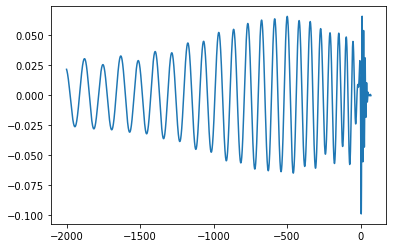

In [41]:
plt.plot(X,y)

(-500.0, 120.0)

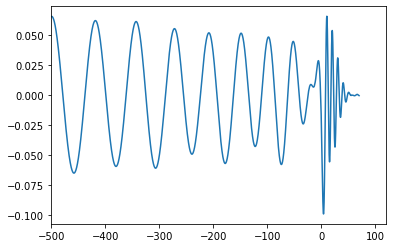

In [42]:
plt.plot(X,y)
plt.xlim(-500, 120)

In [43]:
X_idxs = np.arange(len(X))
X_training_idxs = X_idxs[::2]
X_validation_idxs = X_idxs[1::2]

In [44]:
len(X_idxs)

20700

In [45]:
len(X_training_idxs)

10350

In [46]:
len(X_validation_idxs)

10350

In [47]:
X_train = X[X_training_idxs]
y_train = y[X_training_idxs]

X_val = X[X_validation_idxs]
y_val = y[X_validation_idxs]

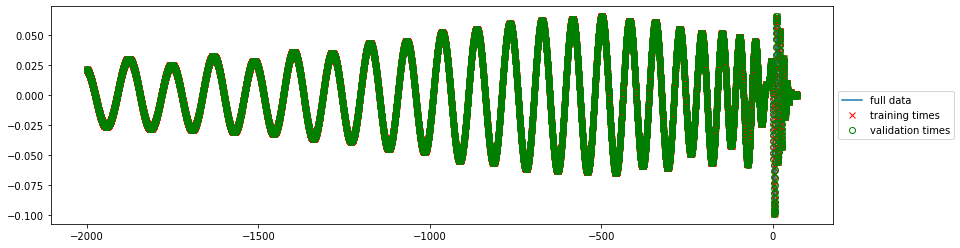

In [48]:
plt.figure(figsize=(14, 4))
plt.plot(X, y, label='full data')
plt.plot(X_train, y_train, 'rx', label='training times')
plt.plot(X_val, y_val, 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-100.0, 100.0)

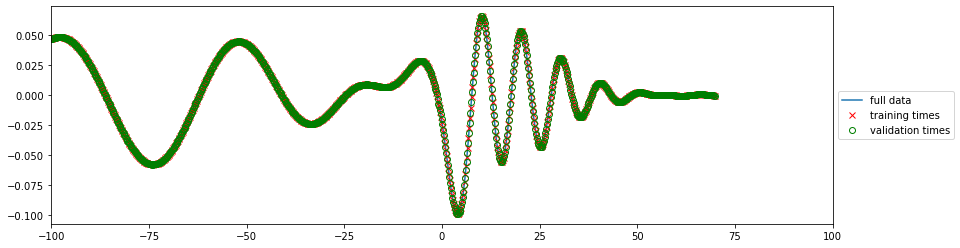

In [49]:
plt.figure(figsize=(14, 4))
plt.plot(X, y, label='full data')
plt.plot(X_train, y_train, 'rx', label='training times')
plt.plot(X_val, y_val, 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

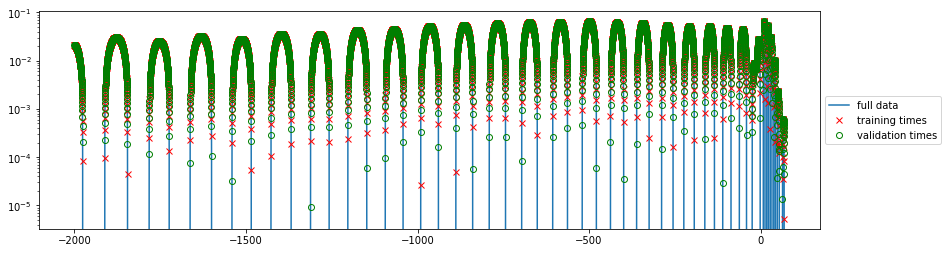

In [50]:
plt.figure(figsize=(14, 4))
plt.plot(X, y, label='full data')
plt.plot(X_train, y_train, 'rx', label='training times')
plt.plot(X_val, y_val, 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

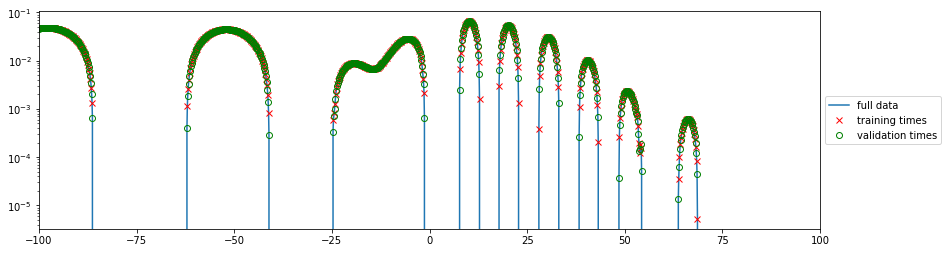

In [51]:
plt.figure(figsize=(14, 4))
plt.plot(X, y, label='full data')
plt.plot(X_train, y_train, 'rx', label='training times')
plt.plot(X_val, y_val, 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)
plt.yscale('log')

In [52]:
feature_range=(-0.5, 0.5)
# feature_range=(0, 1)
# feature_range=(-1, 0)
X_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=feature_range)
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)

X_scaled = X_scaler.transform(X)


In [53]:
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=feature_range)
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)

y_scaled = y_scaler.transform(y)

In [54]:

y_scaled.shape

(20700, 1)

Text(0.5, 1.0, 'scaled data')

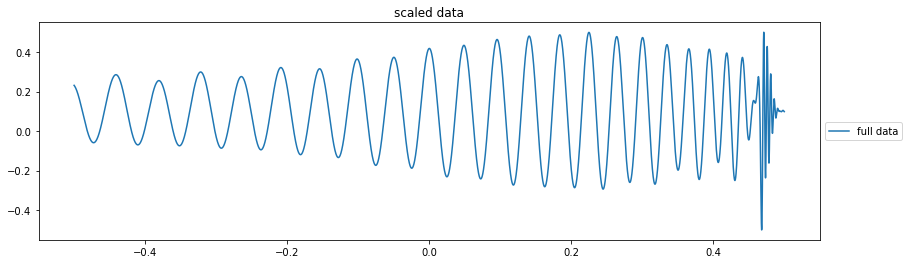

In [55]:
plt.figure(figsize=(14, 4))
plt.plot(X_scaled, y_scaled, label='full data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("scaled data")

In [58]:
def compile_model(model_version, learning_rate=1e-3):
    activation = 'relu'
    units = 256
    # units = 512
    n_layers = 3
    # n_layers = 9
    # gaussian_projection = 8
    gaussian_projection = 16
    # gaussian_projection = 32
    # gaussian_projection = 256
    # gaussian_scale = 1
    # gaussian_scale = 3
    # gaussian_scale = 5
    gaussian_scale = 5*4
    # gaussian_scale = 20

    inputs = tf.keras.Input(shape=(1,))
    
    if model_version == "RFF":
        x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(inputs)
        x = tf.keras.layers.Dense(units, activation)(x)
    elif model_version == "dense":
        x = tf.keras.layers.Dense(units, activation)(inputs)
    else:
        raise ValueError()

    for i in range(n_layers-1):
        x = tf.keras.layers.Dense(units, activation)(x)
        # x = tf.keras.layers.LayerNormalization()(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model

def fit_model(model, X_train, y_train, epochs, verbose, batch_size, validation_data, threshold=1e-7, initial_epoch=0):
    callbacks = [
    #     tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        # wispy.callbacks.ThresholdCallback(threshold),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=1000, factor=0.1, monitor='val_loss'),
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True),
    ]
    # callbacks=None
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data, initial_epoch=initial_epoch)
    return history, model

In [59]:
def run_model(model_version, X_train, y_train, epochs, batch_size, validation_data=None, learning_rate=1e-3, verbose=1, threshold=1e-7):
    
    model = compile_model(model_version, learning_rate)
    
    history, model = fit_model(
        model,
        X_train=X_train,
        y_train=y_train,
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size,
        validation_data=validation_data,
        threshold=threshold,
    )
    
    return history, model

# fits

In [60]:
X_train.shape

(10350, 1)

In [61]:
epochs=100
# epochs=3000
# batch_size=32
# batch_size=64
# batch_size=128
# batch_size=512
batch_size=1024
# batch_size=2048
# batch_size=4096
# batch_size=8192
validation_data=(X_val_scaled, y_val_scaled)
learning_rate=1e-3
verbose=1
threshold=1e-8

In [62]:
history={}
model={}

In [63]:
fit_params=dict(X_train=X_train_scaled, y_train=y_train_scaled, epochs=epochs, batch_size=batch_size, validation_data=validation_data, learning_rate=learning_rate, verbose=verbose, threshold=threshold)

In [64]:
fit_params.keys()

dict_keys(['X_train', 'y_train', 'epochs', 'batch_size', 'validation_data', 'learning_rate', 'verbose', 'threshold'])

In [65]:
%%time
model_version='RFF'
fit_params.update({'model_version':model_version})
history[model_version], model[model_version] = run_model(**fit_params)

Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.0371

2022-06-18 22:41:33.958570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 22ms/step - loss: 0.0346 - val_loss: 0.0047 - lr: 0.0010
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.0054

2022-06-18 22:41:34.205017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 12ms/step - loss: 0.0053 - val_loss: 0.0018 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0017 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 9.6316e-04 - val_loss: 8.6200e-04 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 8.3061e-04 - val_loss: 7.2886e-04 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 13ms/step - loss: 7.2331e-04 - val_loss: 6.5325e-04 - lr: 0.0010
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 6.5146e-04 - val_loss: 6.0087e-04 - lr: 0.0010
Epoch 9/100
11/11 [==============================] - 0s 12ms/step - loss: 6.2990e-04 - val_loss: 5.7755e-04 - lr: 0.0010
Epoch 10/100
11/11 [==============================] - 0s 12ms/step -

In [66]:
%%time
model_version='dense'
fit_params.update({'model_version':model_version})
history[model_version], model[model_version] = run_model(**fit_params)

Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.0436

2022-06-18 22:41:50.271912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-18 22:41:50.472857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 19ms/step - loss: 0.0435 - val_loss: 0.0415 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0413 - val_loss: 0.0411 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0410 - val_loss: 0.0409 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0410 - val_loss: 0.0409 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0409 - val_loss: 0.0409 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0410 - val_loss: 0.0409 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0409 - val_loss: 0.0409 - lr: 0.0010
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0410 - val_loss: 0.0409 - lr: 0.0010
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0409 - val_loss: 0.0409 - lr: 0.00

# metrics

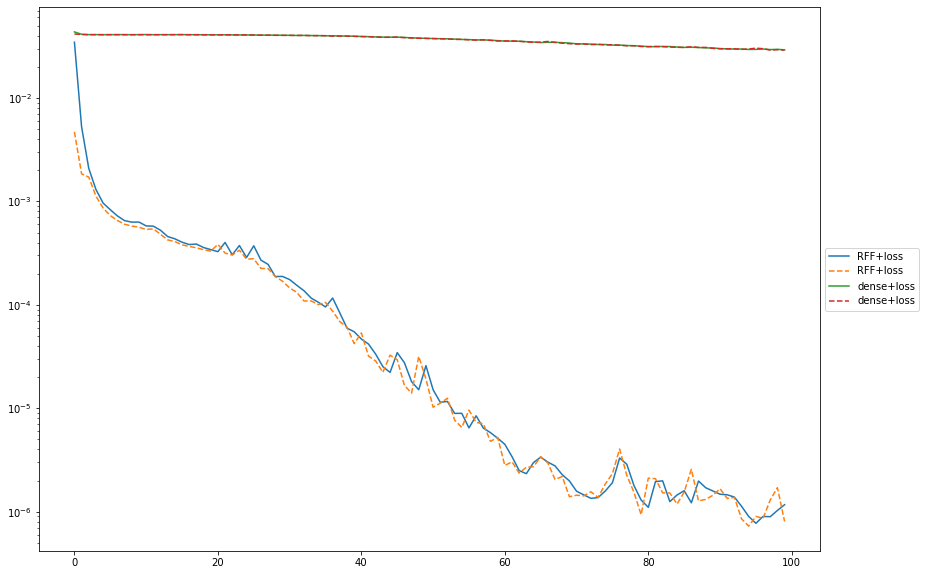

In [67]:
plt.figure(figsize=(14,10))
for k in history.keys():
    plt.plot(history[k].history['loss'], label=f"{k}+loss")
    plt.plot(history[k].history['val_loss'], label=f"{k}+loss", ls='--')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

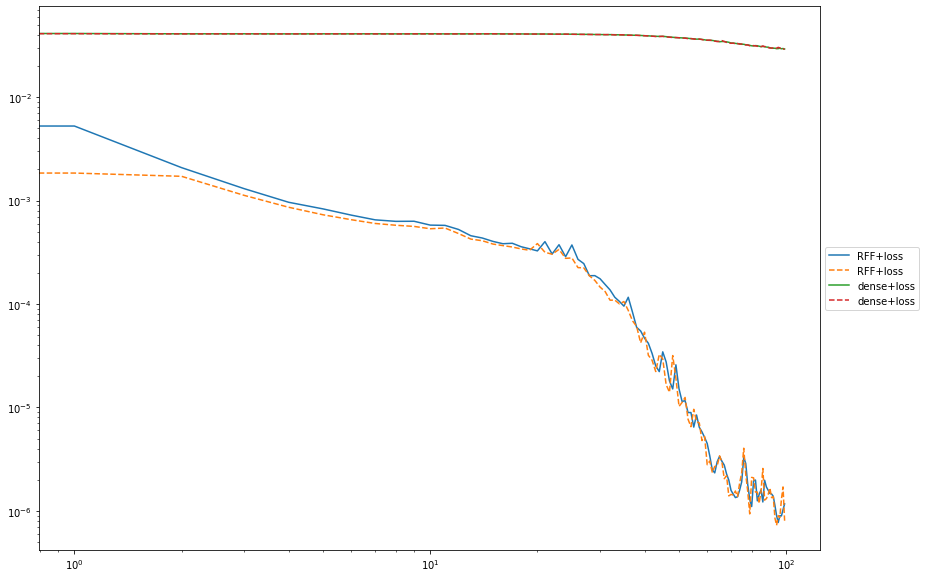

In [68]:
plt.figure(figsize=(14,10))
for k in history.keys():
    plt.plot(history[k].history['loss'], label=f"{k}+loss")
    plt.plot(history[k].history['val_loss'], label=f"{k}+loss", ls='--')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

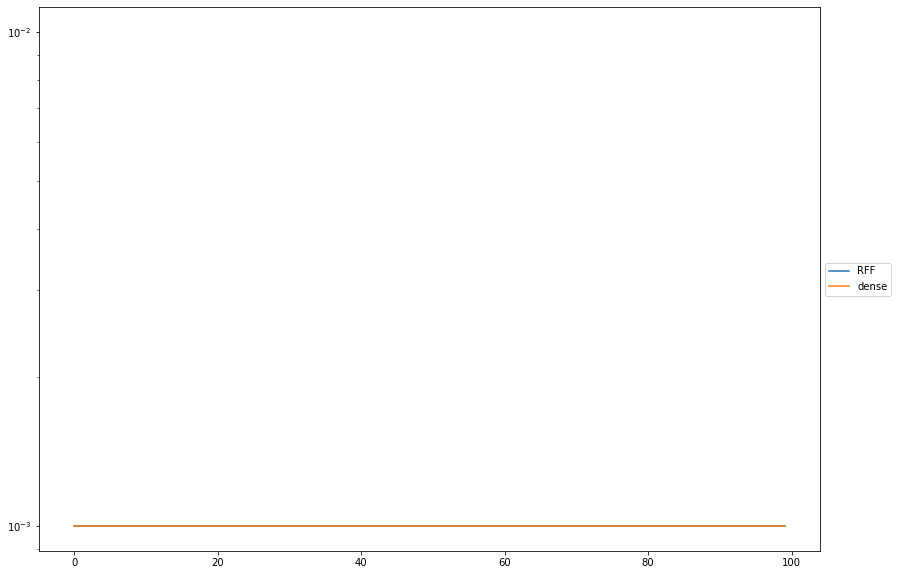

In [69]:
try:
    plt.figure(figsize=(14,10))
    for k in history.keys():
        plt.plot(history[k].history['lr'], label=f"{k}")
    plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
except:
    pass

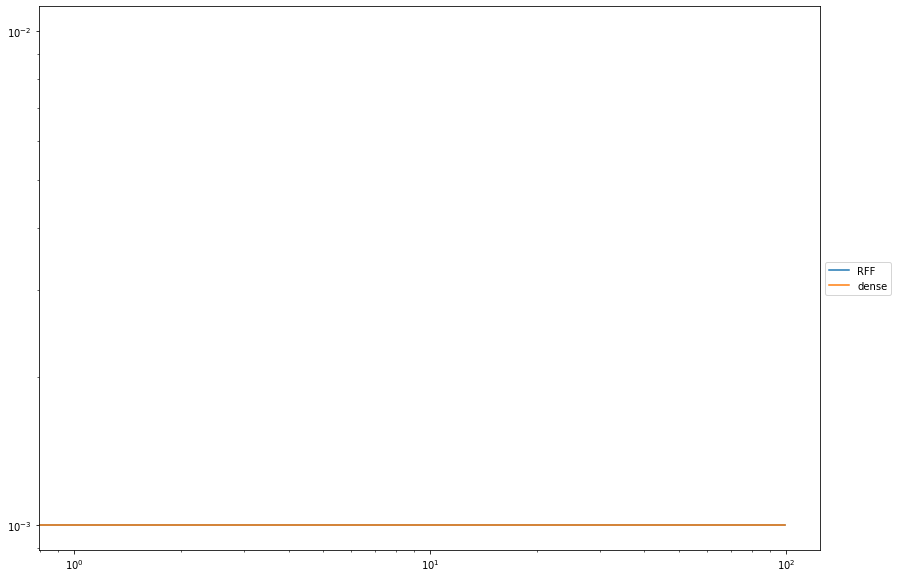

In [70]:
try:
    plt.figure(figsize=(14,10))
    for k in history.keys():
        plt.plot(history[k].history['lr'], label=f"{k}")
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
except:
    pass

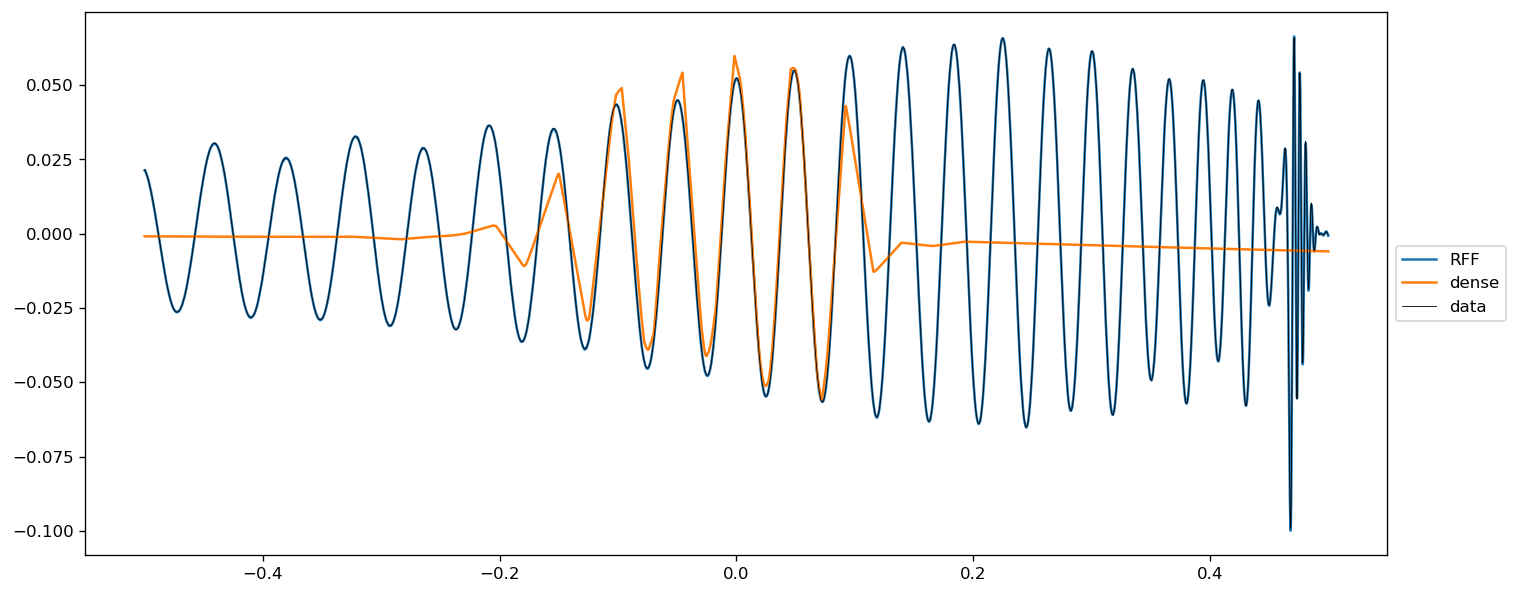

In [71]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    plt.plot(X_scaled, y_scaler.inverse_transform(model[k](X_scaled)), label=f'{k}')
plt.plot(X_scaled, y_scaler.inverse_transform(y_scaled), c='k', label='data', lw=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.yscale('log')

(0.4, 0.55)

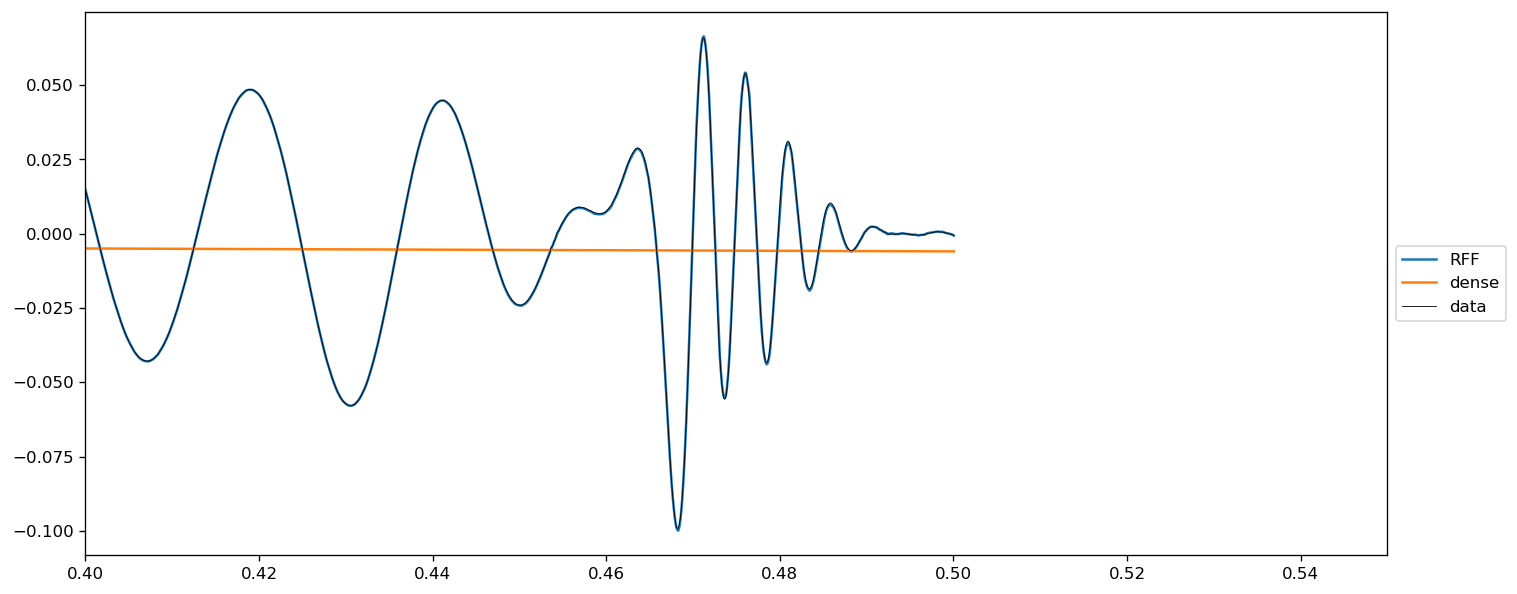

In [72]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    plt.plot(X_scaled, y_scaler.inverse_transform(model[k](X_scaled)), label=f'{k}')
plt.plot(X_scaled, y_scaler.inverse_transform(y_scaled), c='k', label='data', lw=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.yscale('log')
plt.xlim(0.4, 0.55)

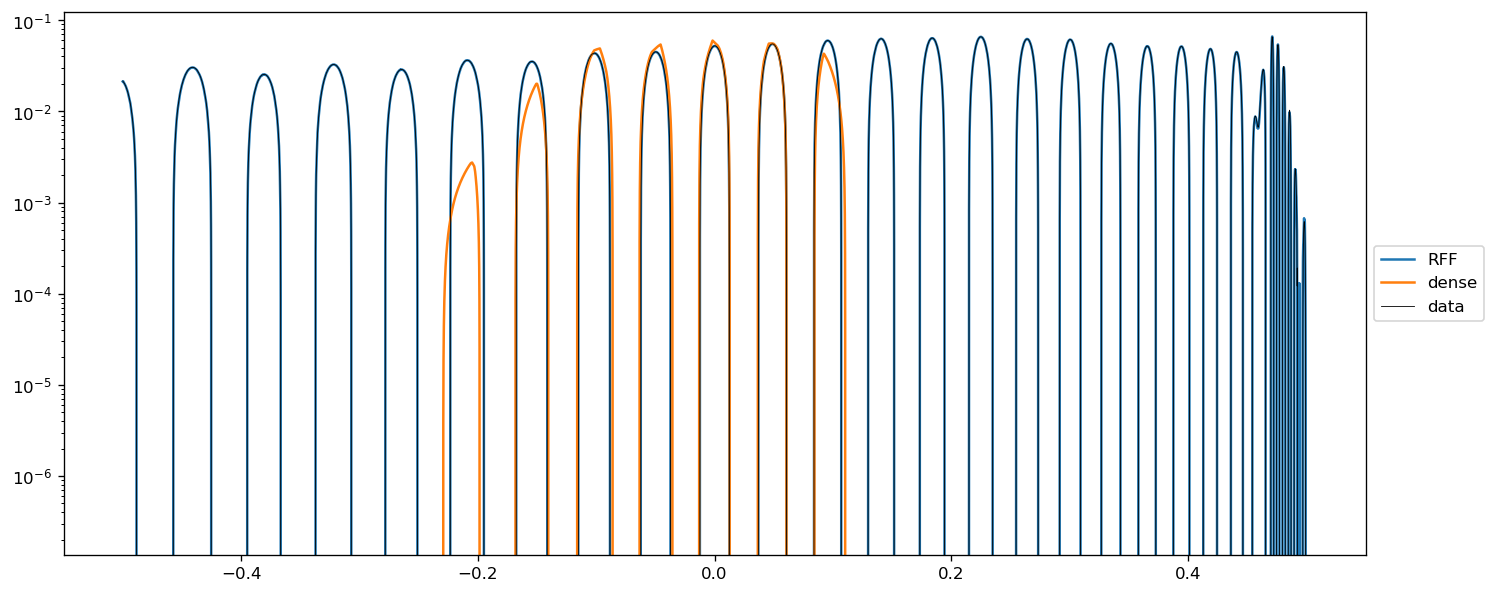

In [73]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    plt.plot(X_scaled, y_scaler.inverse_transform(model[k](X_scaled)), label=f'{k}')
plt.plot(X_scaled, y_scaler.inverse_transform(y_scaled), c='k', label='data', lw=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

(0.4, 0.55)

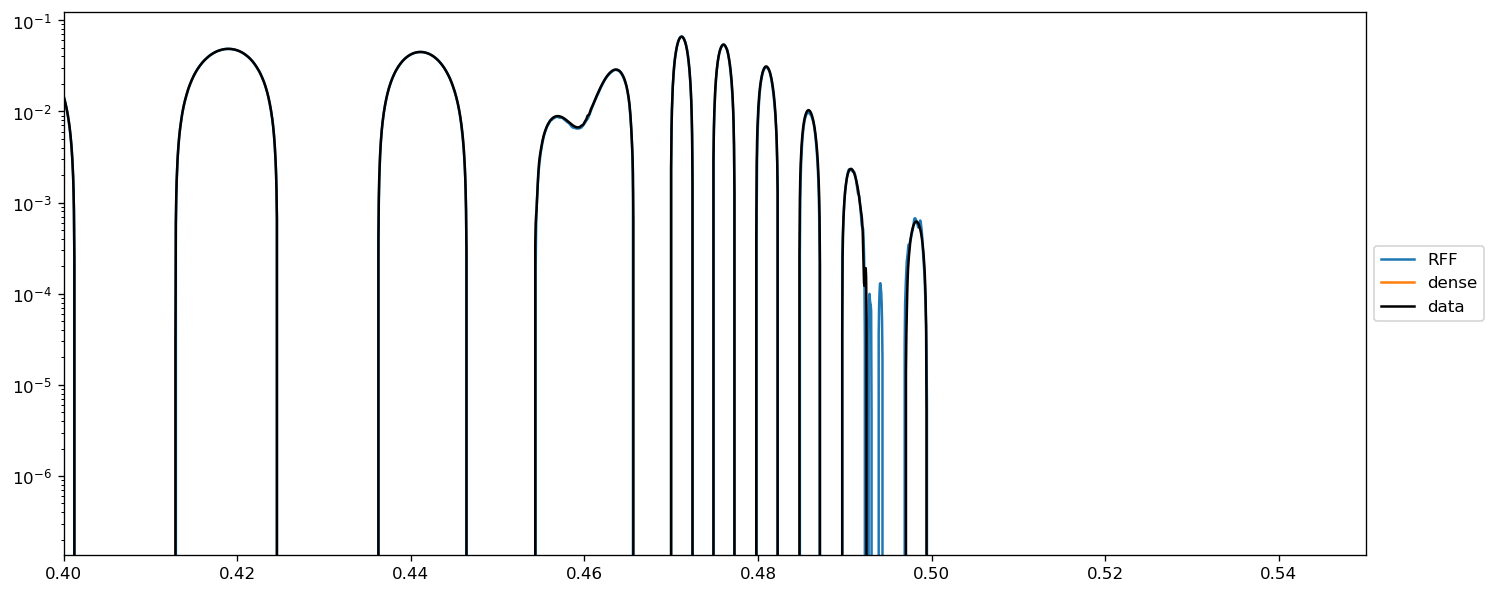

In [74]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    plt.plot(X_scaled, y_scaler.inverse_transform(model[k](X_scaled)), label=f'{k}')
plt.plot(X_scaled, y_scaler.inverse_transform(y_scaled), c='k', label='data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.xlim(0.4, 0.55)

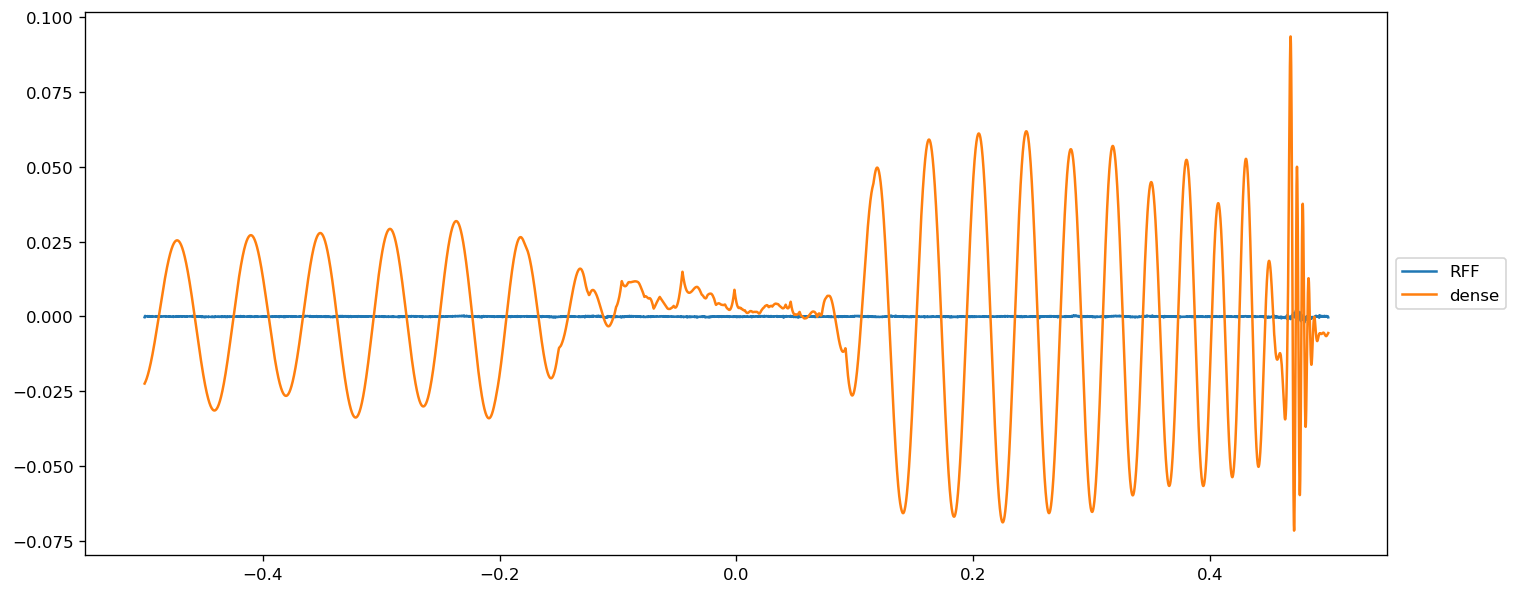

In [75]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    y1 = y_scaler.inverse_transform(model[k](X_scaled))
    y2 = y_scaler.inverse_transform(y_scaled)
    plt.plot(X_scaled, y1-y2, label=f'{k}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

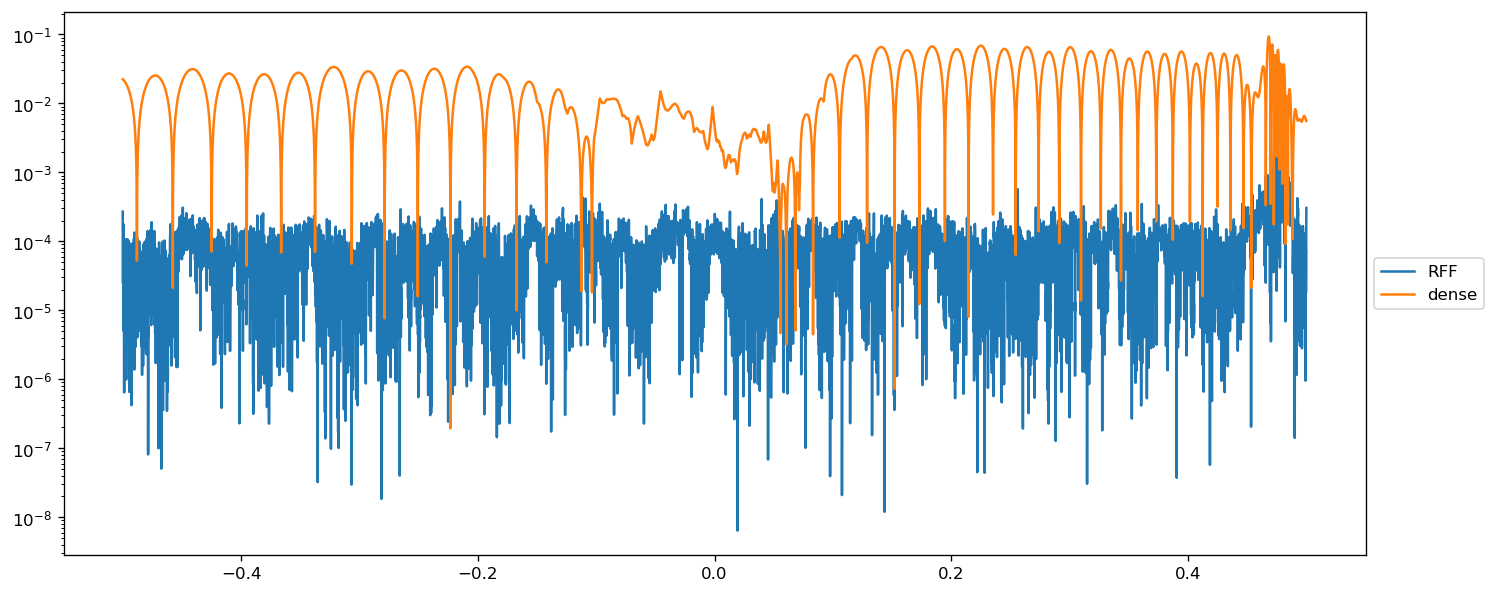

In [76]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    y1 = y_scaler.inverse_transform(model[k](X_scaled))
    y2 = y_scaler.inverse_transform(y_scaled)
    plt.plot(X_scaled, np.abs(y1-y2), label=f'{k}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

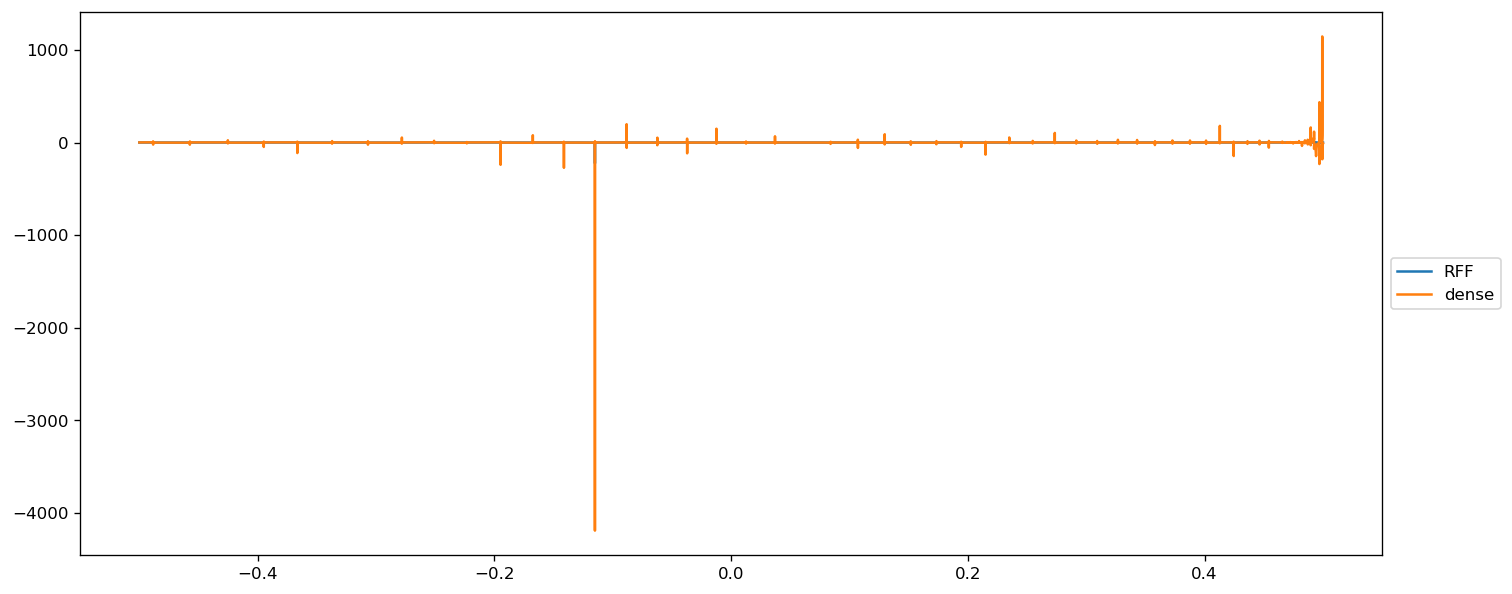

In [77]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    y1 = y_scaler.inverse_transform(model[k](X_scaled))
    y2 = y_scaler.inverse_transform(y_scaled)
    plt.plot(X_scaled, np.abs(y1-y2)/y2, label=f'{k}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.yscale('log')

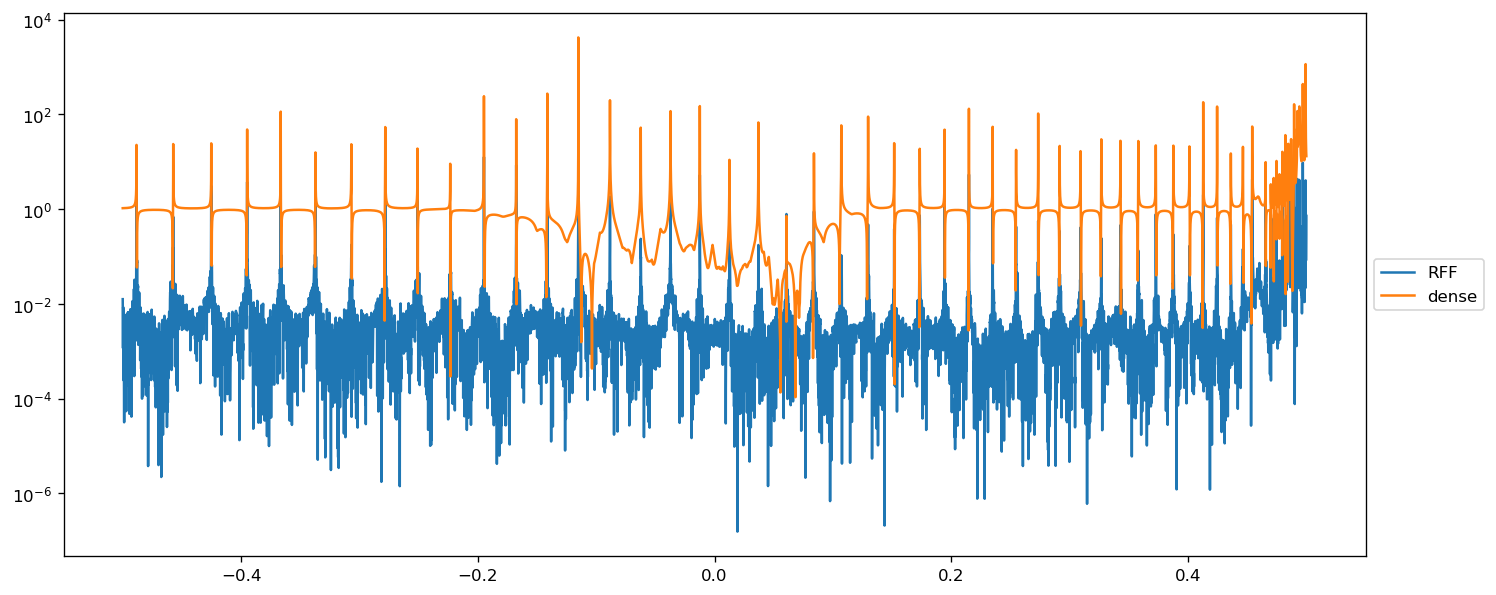

In [78]:
plt.figure(figsize=(14, 6), dpi=120)
for k in model.keys():
    y1 = y_scaler.inverse_transform(model[k](X_scaled))
    y2 = y_scaler.inverse_transform(y_scaled)
    plt.plot(X_scaled, np.abs((y1-y2)/y2), label=f'{k}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')